# West Nile Virus Data Story
https://www.kaggle.com/c/predict-west-nile-virus
#### Instructions:
Pick a dataset - ideally the dataset for your Capstone. If for some reason you want to do this on a different data set, you can find one on Mode Analytics or Google's public data sets directory, or pick another one you like from elsewhere.

Get going by asking the following questions and looking for the answers with some code and plots:
Can you count something interesting?
Can you find some trends (high, low, increase, decrease, anomalies)?
Can you make a bar plot or a histogram?
Can you compare two related quantities?
Can you make a scatterplot?
Can you make a time-series plot?

Having made these plots, what are some insights you get from them? Do you see any correlations? Is there a hypothesis you would like to investigate further? What other questions do they lead you to ask?

By now you’ve asked a bunch of questions, and found some neat insights. Is there an interesting narrative, a way of presenting the insights using text and plots from the above, that tells a compelling story? As you work out this story, what are some other trends/relationships you think will make it more complete?


#### Update:
Use seaborn to plot pair-wise variables relationship. 




In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
from scipy import stats
% matplotlib inline

In [2]:
# load data 
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
spray = pd.read_csv('spray.csv')
weather = pd.read_csv('weather.csv')
weatherorin = weather

#print 'train col num:',train.shape[1]
#print train.dtypes
#print 'test col num:', test.shape[1]
#print 'spray col num:', spray.shape[1]
#print spray.dtypes
#print 'weather col num:',weather.shape[1]
#print weather.dtypes


### Explore train dataset

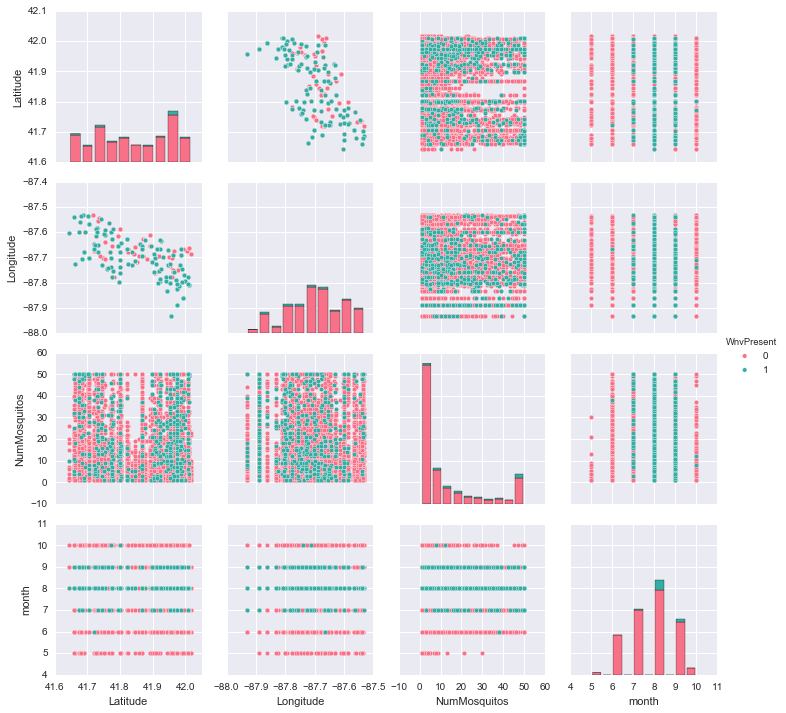

In [3]:
# add month
# train['month'] = train['Date'].dt.month  # not work
train['month'] = pd.DatetimeIndex(train['Date']).month
train.dtypes

t = sns.pairplot(train,vars =['Latitude','Longitude','NumMosquitos','month'],hue = 'WnvPresent',palette = 'husl')

### Explore weather data

In [4]:
# replace missing value with 0
#weather = weather.replace(["M","  T"],np.nan)
weather = weather.replace(['M','  T'],-10)

# convert string to float
weathervars = ['WetBulb', 'Heat','Cool','PrecipTotal']
for i in weathervars:
    try:
        weather[i] = weather[i].astype('float64')
    except ValueError:
        print 
        print set(weather[i])

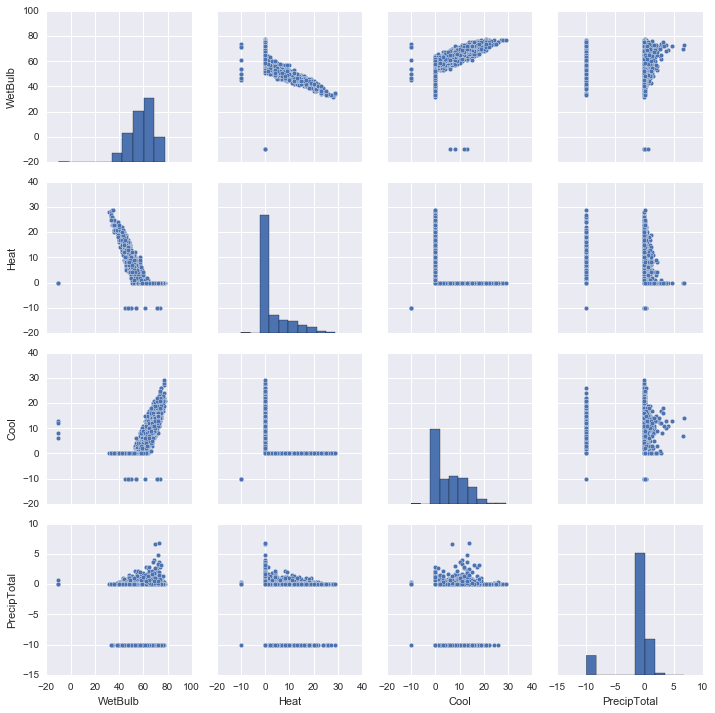

In [5]:
w = sns.pairplot(weather, vars = ['WetBulb','Heat','Cool','PrecipTotal'], dropna = True)

### Explore relationship between type of mosquitos and detection of WN virus
* West virus was prensented in Mosquitos: CULEX PIPIENS and CULEX RESTUANS
* Two species of Culex mosquitoes are common throughout much of North America. Culex restuans Theobold is a native species, whereas Culex pipiens L. is a European immigrant that has been in North America since the 1600s.
http://ee.oxfordjournals.org/content/early/2015/06/26/ee.nvv094

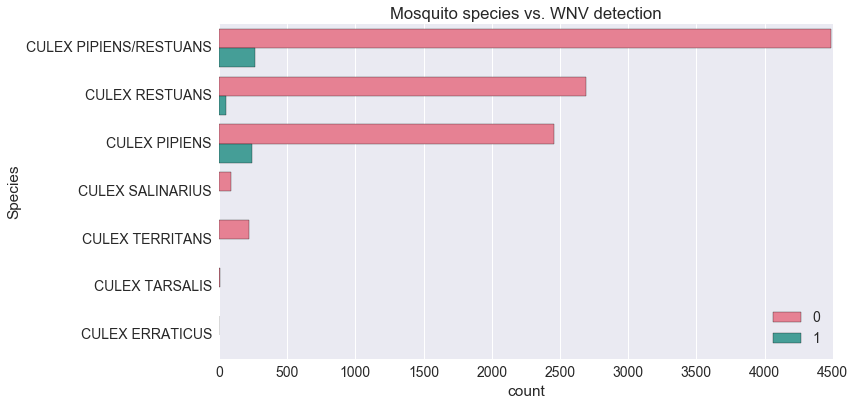

In [6]:
# add new columns for each element of categorical data of mosquitos species
sns.set(font_scale = 1.4)
fig,ax = plt.subplots(figsize = (11,6))
sns.countplot(y = 'Species', hue = 'WnvPresent',data = train, palette = 'husl')
plt.legend(loc = 'lower right')
plt.title('Mosquito species vs. WNV detection')
plt.show()

### Explore spray dataset

In [7]:
# replace nan 
spray.fillna('7:44:32 PM', inplace = True)
#spray.fillna('ffill')  # didn't work
spray.loc[1032,:]

Date         2011-09-07
Time         7:44:32 PM
Latitude         41.988
Longitude      -87.7946
Name: 1032, dtype: object

In [8]:
# add month and hour
spray['month'] = pd.DatetimeIndex(spray['Date']).month
spray['hour'] = pd.DatetimeIndex(spray['Time']).hour
#spray.replace('nan',-1)
set(spray['hour'])

{0, 10, 18, 19, 20, 21, 22, 23}

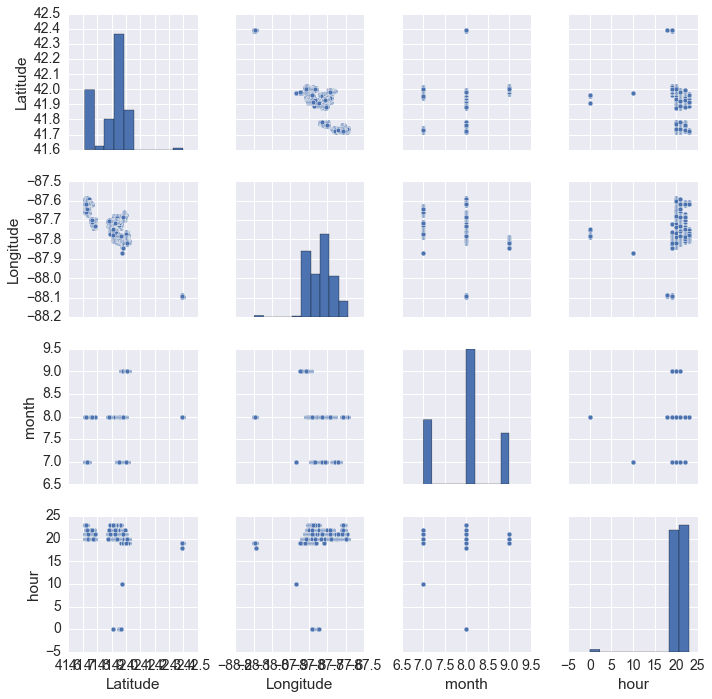

In [9]:
s = sns.pairplot(spray,vars =['Latitude','Longitude','month','hour'])

### Feature selection 
###### http://scikit-learn.org/stable/modules/feature_selection.html
* Removing features with low variance
* Univariate feature selection
* Recursive feature selection
* Feature selection using SelectFromModel
 * L1-based feature selection
 * Randomized sparse models
 * Tree-based feature selection
* Feature selections pipline



Tried decistion tree and it indicate 'Latitude', 'Longitude', 'NumMosquitos', 'month', 'Block' are five most imporant features.
Haven't taken weather and spary into consideration yet.


In [10]:
# add dummpy variable
mos = train.Species
mostype = set(mos)
trainvars = ['Latitude','Longitude','NumMosquitos','month','Block','AddressAccuracy']
for i in mostype:
    train[i] = train.Species == i
    train[i]= [int(elem) for elem in train[i]]
    trainvars.append(i)
train.head(1)


,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,month,CULEX TARSALIS,CULEX PIPIENS,CULEX TERRITANS,CULEX SALINARIUS,CULEX ERRATICUS,CULEX PIPIENS/RESTUANS,CULEX RESTUANS
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1,0,5,0,0,0,0,0,1,0


In [11]:
# based upon decision tree
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel


sklearn.datasets.base.Bunch

In [12]:
trainsub = train[trainvars].values
traintarget = train['WnvPresent'].values
clf = ExtraTreesClassifier()
clf = clf.fit(trainsub,traintarget)
print clf.feature_importances_
print trainvars

[  1.03597765e-01   9.81884926e-02   5.10310571e-01   1.43754989e-01
   8.98397014e-02   3.02357427e-02   1.23851459e-07   1.00631905e-02
   4.00621125e-04   1.92597964e-04   6.08365262e-06   4.20377717e-03
   9.20634345e-03]
['Latitude', 'Longitude', 'NumMosquitos', 'month', 'Block', 'AddressAccuracy', 'CULEX TARSALIS', 'CULEX PIPIENS', 'CULEX TERRITANS', 'CULEX SALINARIUS', 'CULEX ERRATICUS', 'CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS']


In [13]:
model = SelectFromModel(clf,prefit= True)
X_new = model.transform(trainsub)
print X_new.shape
print trainsub.shape


(10506L, 5L)
(10506L, 13L)
